In [ ]:
!git clone https://github.com/shariqfarooq123/AdaBins

Cloning into 'AdaBins'...
remote: Enumerating objects: 70, done.
remote: Total 70 (delta 0), reused 0 (delta 0), pack-reused 70
Unpacking objects: 100% (70/70), done.


In [ ]:
!mkdir ./AdaBins/pretrained

In [ ]:
!pip install gdown


In [ ]:
!gdown --id 1NvjGQE9YjStIHG06aBsnLpPJYVnv-TMb --output AdaBins_nyu.pt

Downloading...
From: https://drive.google.com/uc?id=1NvjGQE9YjStIHG06aBsnLpPJYVnv-TMb
To: /content/AdaBins_nyu.pt
941MB [00:18, 51.7MB/s]


In [ ]:
!cp AdaBins_nyu.pt AdaBins/pretrained/

In [ ]:
!cd ./AdaBins

In [ ]:
import os
path= os.getcwd()
print(path)

/content


In [ ]:
import glob
import os

import numpy as np
import torch
import torch.nn as nn
from PIL import Image
from torchvision import transforms
from tqdm import tqdm

from AdaBins import model_io
from AdaBins import utils
from AdaBins.models import UnetAdaptiveBins

In [ ]:



def _is_pil_image(img):
    return isinstance(img, Image.Image)


def _is_numpy_image(img):
    return isinstance(img, np.ndarray) and (img.ndim in {2, 3})


class ToTensor(object):
    def __init__(self):
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    def __call__(self, image, target_size=(640, 480)):
        # image = image.resize(target_size)
        image = self.to_tensor(image)
        image = self.normalize(image)
        return image

    def to_tensor(self, pic):
        if not (_is_pil_image(pic) or _is_numpy_image(pic)):
            raise TypeError(
                'pic should be PIL Image or ndarray. Got {}'.format(type(pic)))

        if isinstance(pic, np.ndarray):
            img = torch.from_numpy(pic.transpose((2, 0, 1)))
            return img

        # handle PIL Image
        if pic.mode == 'I':
            img = torch.from_numpy(np.array(pic, np.int32, copy=False))
        elif pic.mode == 'I;16':
            img = torch.from_numpy(np.array(pic, np.int16, copy=False))
        else:
            img = torch.ByteTensor(torch.ByteStorage.from_buffer(pic.tobytes()))
        # PIL image mode: 1, L, P, I, F, RGB, YCbCr, RGBA, CMYK
        if pic.mode == 'YCbCr':
            nchannel = 3
        elif pic.mode == 'I;16':
            nchannel = 1
        else:
            nchannel = len(pic.mode)
        img = img.view(pic.size[1], pic.size[0], nchannel)

        img = img.transpose(0, 1).transpose(0, 2).contiguous()
        if isinstance(img, torch.ByteTensor):
            return img.float()
        else:
            return img


class InferenceHelper:
    def __init__(self, dataset='nyu', device='cuda:0'):
        self.toTensor = ToTensor()
        self.device = device
        if dataset == 'nyu':
            self.min_depth = 1e-3
            self.max_depth = 10
            self.saving_factor = 1000  # used to save in 16 bit
            model = UnetAdaptiveBins.build(n_bins=256, min_val=self.min_depth, max_val=self.max_depth)
            pretrained_path = "./AdaBins/pretrained/AdaBins_nyu.pt"
        elif dataset == 'kitti':
            self.min_depth = 1e-3
            self.max_depth = 80
            self.saving_factor = 256
            model = UnetAdaptiveBins.build(n_bins=256, min_val=self.min_depth, max_val=self.max_depth)
            pretrained_path = "./pretrained/AdaBins_kitti.pt"
        else:
            raise ValueError("dataset can be either 'nyu' or 'kitti' but got {}".format(dataset))

        model, _, _ = model_io.load_checkpoint(pretrained_path, model)
        model.eval()
        self.model = model.to(self.device)

    @torch.no_grad()
    def predict_pil(self, pil_image, visualized=False):
        # pil_image = pil_image.resize((640, 480))
        img = np.asarray(pil_image) / 255.

        img = self.toTensor(img).unsqueeze(0).float().to(self.device)
        bin_centers, pred = self.predict(img)

        if visualized:
            viz = utils.colorize(torch.from_numpy(pred).unsqueeze(0), vmin=None, vmax=None, cmap='magma')
            # pred = np.asarray(pred*1000, dtype='uint16')
            viz = Image.fromarray(viz)
            return bin_centers, pred, viz
        return bin_centers, pred

    @torch.no_grad()
    def predict(self, image):
        bins, pred = self.model(image)
        pred = np.clip(pred.cpu().numpy(), self.min_depth, self.max_depth)

        # Flip
        image = torch.Tensor(np.array(image.cpu().numpy())[..., ::-1].copy()).to(self.device)
        pred_lr = self.model(image)[-1]
        pred_lr = np.clip(pred_lr.cpu().numpy()[..., ::-1], self.min_depth, self.max_depth)

        # Take average of original and mirror
        final = 0.5 * (pred + pred_lr)
        final = nn.functional.interpolate(torch.Tensor(final), image.shape[-2:],
                                          mode='bilinear', align_corners=True).cpu().numpy()

        final[final < self.min_depth] = self.min_depth
        final[final > self.max_depth] = self.max_depth
        final[np.isinf(final)] = self.max_depth
        final[np.isnan(final)] = self.min_depth

        centers = 0.5 * (bins[:, 1:] + bins[:, :-1])
        centers = centers.cpu().squeeze().numpy()
        centers = centers[centers > self.min_depth]
        centers = centers[centers < self.max_depth]

        return centers, final

    @torch.no_grad()
    def predict_dir(self, test_dir, out_dir):
        os.makedirs(out_dir, exist_ok=True)
        transform = ToTensor()
        all_files = glob.glob(os.path.join(test_dir, "*"))
        self.model.eval()
        for f in tqdm(all_files):
            image = np.asarray(Image.open(f), dtype='float32') / 255.
            image = transform(image).unsqueeze(0).to(self.device)

            centers, final = self.predict(image)
            # final = final.squeeze().cpu().numpy()

            final = (final * self.saving_factor).astype('uint16')
            basename = os.path.basename(f).split('.')[0]
            save_path = os.path.join(out_dir, basename + ".png")

            Image.fromarray(final).save(save_path)





Loading base model ()...

Using cache found in /root/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master


Done.
Removing last two layers (global_pool & classifier).
Building Encoder-Decoder model..Done.
took :2.6354541778564453s


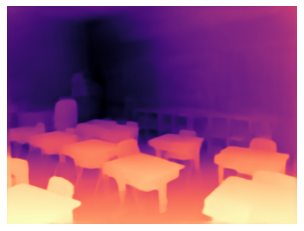

In [ ]:
if __name__ == '__main__':
    import matplotlib.pyplot as plt
    from time import time
    import os

    path=os.getcwd()
    test_path=path+"//AdaBins//test_imgs//"
    img_l=os.listdir(test_path)
    for i in img_l:

        img = Image.open(test_path+i)
        start = time()
        inferHelper = InferenceHelper()
        centers, pred = inferHelper.predict_pil(img)
        print(f"took :{time() - start}s")
        plt.imshow(pred.squeeze(), cmap='magma_r')
        plt.axis('off')
        plt.imshow
        #ipath=path+"/deep/"+i
        #plt.savefig(ipath,bbox_inches="tight")
